In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/my-classified-project/chatbot_dataset.xlsx


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "/kaggle/input/my-classified-project/chatbot_dataset.xlsx"
df = pd.read_excel(file_path, sheet_name='Result 1')

In [17]:
# Basic info and missing values
print("Dataset Info:\n")
df.info()
print("\nMissing Values:\n", df.isnull().sum())

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1358 entries, 0 to 1357
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   session_id        1358 non-null   int64 
 1   message_time      1358 non-null   object
 2   user_message      1358 non-null   object
 3   chatbot_response  1358 non-null   object
 4   response_source   1358 non-null   object
 5   categories        1358 non-null   object
 6   intent_name       1358 non-null   object
dtypes: int64(1), object(6)
memory usage: 74.4+ KB

Missing Values:
 session_id          0
message_time        0
user_message        0
chatbot_response    0
response_source     0
categories          0
intent_name         0
dtype: int64


In [18]:
# Summary statistics (for categorical variables)
print("\nCategorical Value Counts:\n")
for col in ['response_source', 'categories', 'intent_name']:
    print(df[col].value_counts(), "\n")


Categorical Value Counts:

response_source
Generative AI    709
NLU              649
Name: count, dtype: int64 

categories
General conversation    282
Services                154
Other                    94
Apps                     94
Japeto Chat              92
Support                  80
About Japeto             71
Paige                    70
Compliance               53
Project management       53
Contact                  50
AI services              43
Recruitment              41
Billing                  38
Technical stack          32
Partnerships             31
Websites                 31
Feedback                 19
Pat                      18
Managed hosting          12
Name: count, dtype: int64 

intent_name
AI generated                             709
Hello                                    128
Thanks                                    31
Who made you                              22
Project delivery - app                    22
                                        ... 
DEI -

In [19]:
# Message length analysis
df['user_message_length'] = df['user_message'].astype(str).apply(len)
df['chatbot_response_length'] = df['chatbot_response'].astype(str).apply(len)

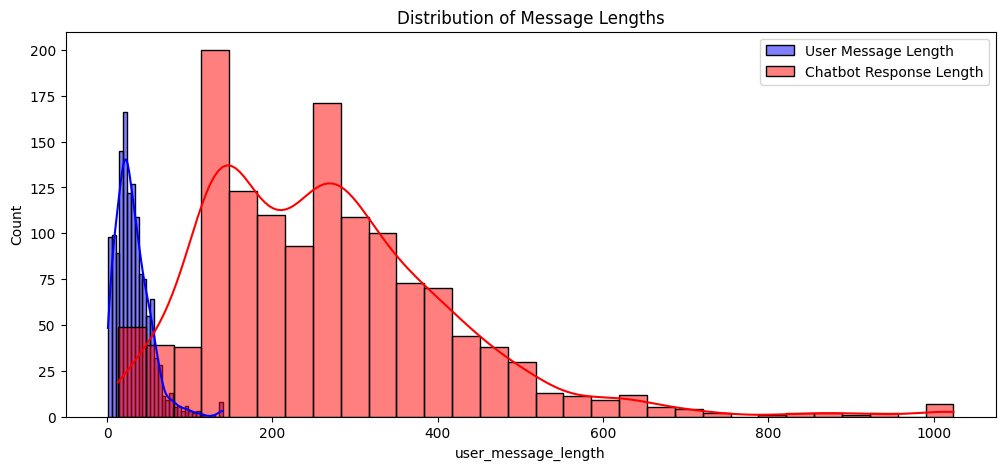

In [20]:
plt.figure(figsize=(12, 5))
sns.histplot(df['user_message_length'], bins=30, kde=True, color='blue', label='User Message Length')
sns.histplot(df['chatbot_response_length'], bins=30, kde=True, color='red', label='Chatbot Response Length')
plt.legend()
plt.title("Distribution of Message Lengths")
plt.show()

In [21]:
# Time-based analysis
df['message_time'] = pd.to_datetime(df['message_time'])
df['hour'] = df['message_time'].dt.hour
df['day_of_week'] = df['message_time'].dt.day_name()
df['date'] = df['message_time'].dt.date


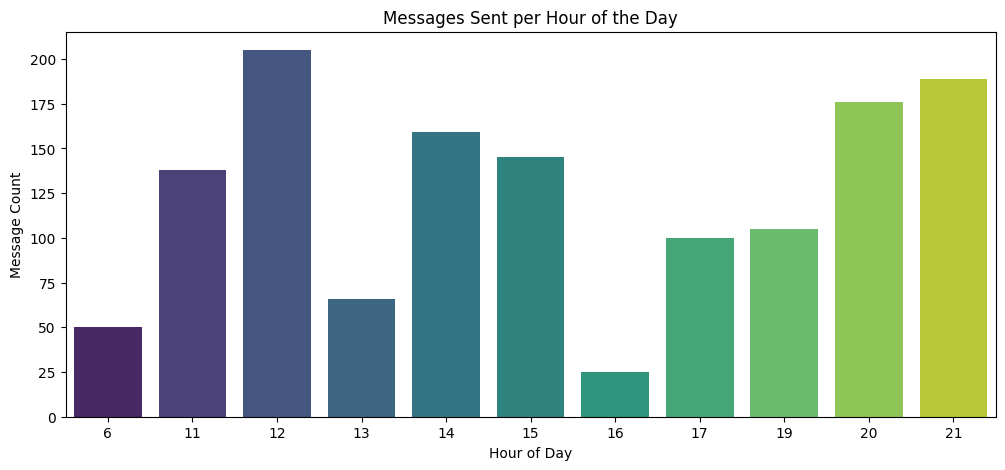

In [22]:
plt.figure(figsize=(12, 5))
sns.countplot(x='hour', data=df, palette='viridis')
plt.title("Messages Sent per Hour of the Day")
plt.xlabel("Hour of Day")
plt.ylabel("Message Count")
plt.show()

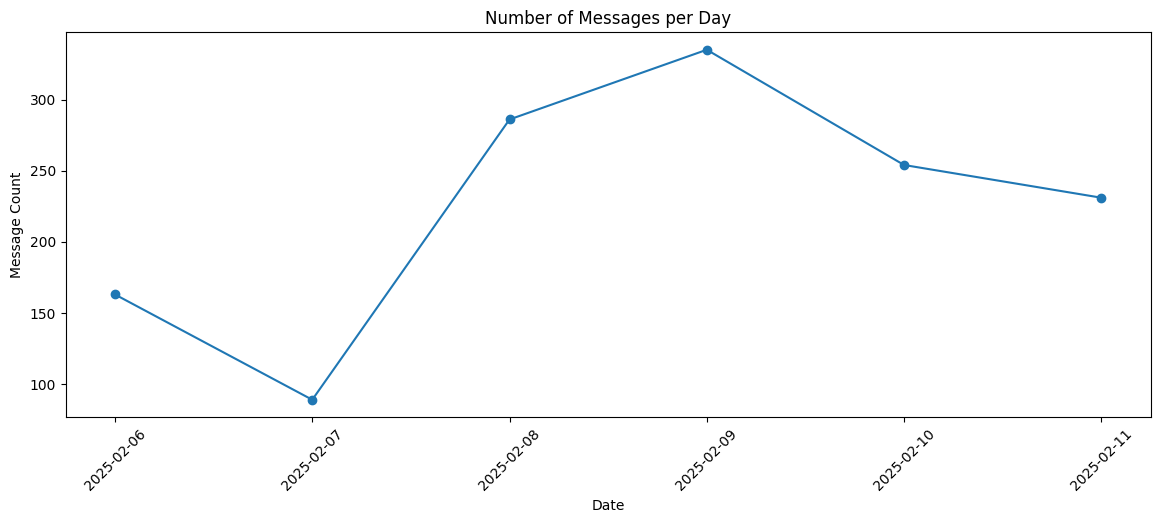

In [23]:
# Daily trend analysis
plt.figure(figsize=(14, 5))
df.groupby('date').size().plot(marker='o', linestyle='-')
plt.xticks(rotation=45)
plt.title("Number of Messages per Day")
plt.xlabel("Date")
plt.ylabel("Message Count")
plt.show()

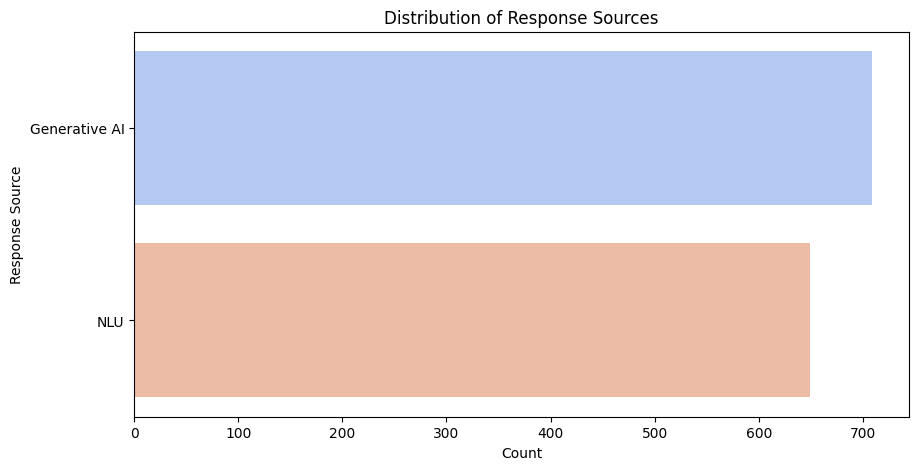

In [24]:
# Distribution of response sources
plt.figure(figsize=(10, 5))
sns.countplot(y=df['response_source'], order=df['response_source'].value_counts().index, palette='coolwarm')
plt.title("Distribution of Response Sources")
plt.xlabel("Count")
plt.ylabel("Response Source")
plt.show()


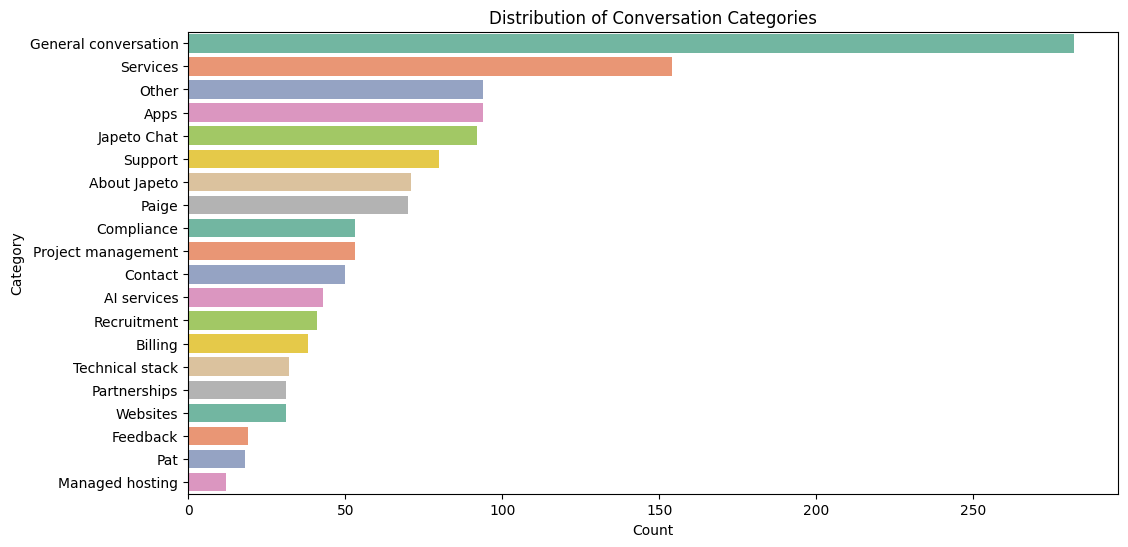

In [25]:
# Intent category distribution
plt.figure(figsize=(12, 6))
sns.countplot(y=df['categories'], order=df['categories'].value_counts().index, palette='Set2')
plt.title("Distribution of Conversation Categories")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

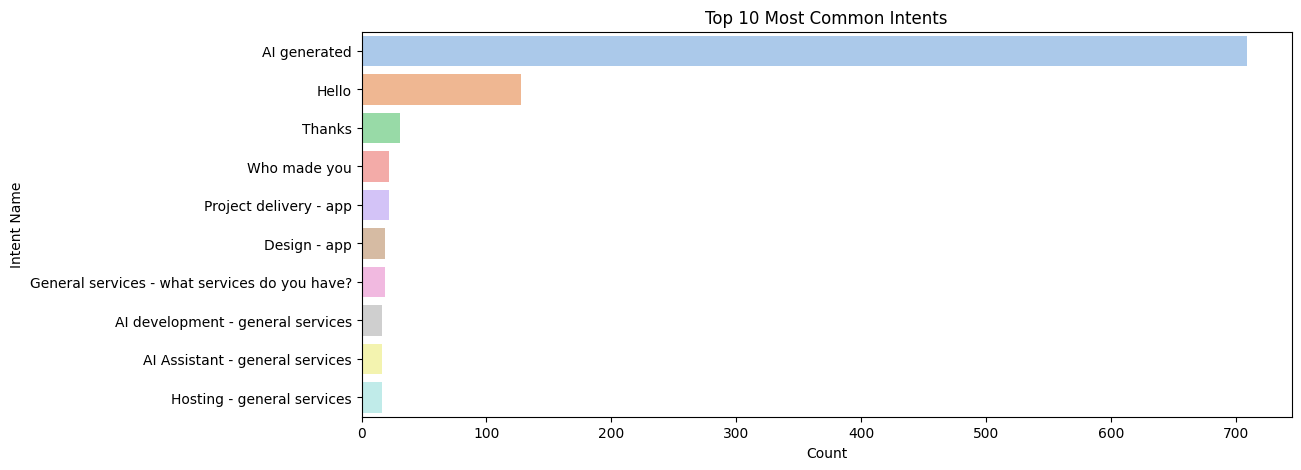

In [26]:
# Top intents
top_intents = df['intent_name'].value_counts().head(10)
plt.figure(figsize=(12, 5))
sns.barplot(x=top_intents.values, y=top_intents.index, palette='pastel')
plt.title("Top 10 Most Common Intents")
plt.xlabel("Count")
plt.ylabel("Intent Name")
plt.show()

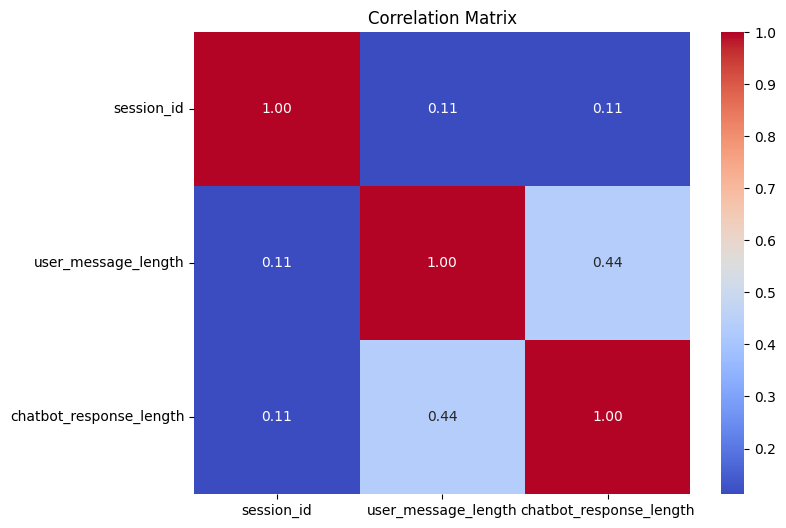

In [27]:

# Correlation analysis (if applicable)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
if not numeric_cols.empty:
    plt.figure(figsize=(8, 6))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show()


# Detailed Explanation of the Chatbot Text Classification Pipeline

This document explains each part of the Python code for a text classification project. The pipeline classifies chatbot responses into categories based on scripted (NLU) responses using **TF-IDF vectorization** and a **Logistic Regression** model.

---

## 1. Environment Setup and Data Loading

### Library Imports
The code imports essential libraries:

- `os`, `re`, `warnings`: For operating system interactions, regular expressions, and handling warnings.
- `pandas`: For data manipulation and reading the Excel file.
- `matplotlib.pyplot` and `seaborn`: For data visualization.
- `scikit-learn` modules: For splitting data, creating a pipeline, hyperparameter tuning (`GridSearchCV`), and evaluation.

### Kaggle Environment Check
The script checks whether it is running on **Kaggle** by looking for the `KAGGLE_URL_BASE` environment variable. Depending on the environment, the dataset path is set accordingly.

### Loading the Dataset
The dataset is loaded from an **Excel file** (`chatbot_dataset.xlsx`) using `pd.read_excel()`, and the available columns are printed.

---

## 2. Mapping and Validating Columns

### Column Mapping
A helper function, `find_column`, is used to match the expected column names (e.g., `categories`, `response_source`, `chatbot_response`) with the actual columns in the dataset. This ensures flexibility if the column names differ slightly.

### Error Handling
The code checks for missing required columns and raises a `ValueError` if any are not found.

---

## 3. Data Filtering

### Filtering Scripted Responses
The dataset is filtered to include only responses where the **`response_source` column equals 'NLU'**. This step ensures that the model is trained on consistent, manually scripted responses.

📌 **Note:** An error is raised if no scripted responses are found.

---

## 4. Visualizing Category Distribution

### Count Plot
A **Seaborn count plot** visualizes the distribution of categories in the filtered data. This helps identify any **class imbalances** that may affect model performance.

---

## 5. Data Splitting and Preprocessing

### Feature and Label Preparation
- **Features (`X`)**: The chatbot response text.
- **Labels (`y`)**: The corresponding category for each response.

### Train-Validation Split
The data is split into **training (80%)** and **validation (20%)** sets using `train_test_split` with **stratification** to maintain category distribution.

### Custom Preprocessor
A function `custom_preprocessor` is defined to:
- Convert text to **lowercase**.
- Remove **punctuation** using regular expressions.

This step standardizes the text for better feature extraction.

---

## 6. Building the Classification Pipeline

### Pipeline Components
A **scikit-learn Pipeline** is created with two main steps:

#### 1️⃣ TF-IDF Vectorization:
The `TfidfVectorizer` converts text into a numerical matrix based on the **TF-IDF score**. It:
- Uses the **custom preprocessor**.
- Removes **English stop words**.

#### 2️⃣ Logistic Regression:
A **multinomial Logistic Regression** model is used for classification. Parameters like `max_iter` and `solver` (`lbfgs`) are set to ensure proper convergence.

---

## 7. Hyperparameter Tuning with GridSearchCV

### Parameter Grid
A range of hyperparameters is defined for both the **TF-IDF vectorizer** and **Logistic Regression**, including:

- `ngram_range` (uni-grams and bi-grams)
- `max_df` and `min_df` (term frequency thresholds)
- `sublinear_tf` (for sublinear term frequency scaling)
- `C` (inverse regularization strength for Logistic Regression)

### Grid Search
`GridSearchCV` performs a **cross-validated search** over the parameter grid (**5-fold CV**) to find the best model configuration based on accuracy.

---

## 8. Model Evaluation and Visualization

### Training
The **grid search** is run on the training data. The **best parameters** found are printed.

### Validation Metrics
The tuned model is evaluated on the **validation set**, and a **classification report** is printed, displaying:
- **Precision**
- **Recall**
- **F1-scores** for each category.

### Confusion Matrix
A **confusion matrix** is generated and visualized using **Seaborn’s heatmap** to analyze **misclassifications** across categories.

---

## 9. Analyzing Model Confidence

### Prediction Probabilities
The model's **prediction probabilities** for each validation sample are computed.

### Histogram Plot
A histogram of the **maximum prediction probabilities** is plotted.  
A **red dashed line** at `0.6` indicates the **confidence threshold** used in later predictions.

---

## 10. Predicting New Categories

### Prediction Function
The function `predict_category` takes a **new chatbot response** and:

1. Computes **prediction probabilities**.
2. Checks if the **maximum probability** exceeds a defined **threshold** (default `0.6`).
   - If the confidence is **low**, it returns:  
     **"Manual Tagging Required"**.
   - Otherwise, it returns the **predicted category**.

### Example Usage
A **sample usage** demonstrates how to predict the category of a new **AI-generated response**.

---

## Conclusion
This pipeline covers the entire process from **data preparation and preprocessing**, through **model building and hyperparameter tuning**, to **evaluation and prediction**.  

Each component is designed to ensure **robust text classification**, making it suitable for **real-world chatbot applications**. 🚀


Detected Kaggle environment.
Dataset columns: ['session_id', 'message_time', 'user_message', 'chatbot_response', 'response_source', 'categories', 'intent_name']


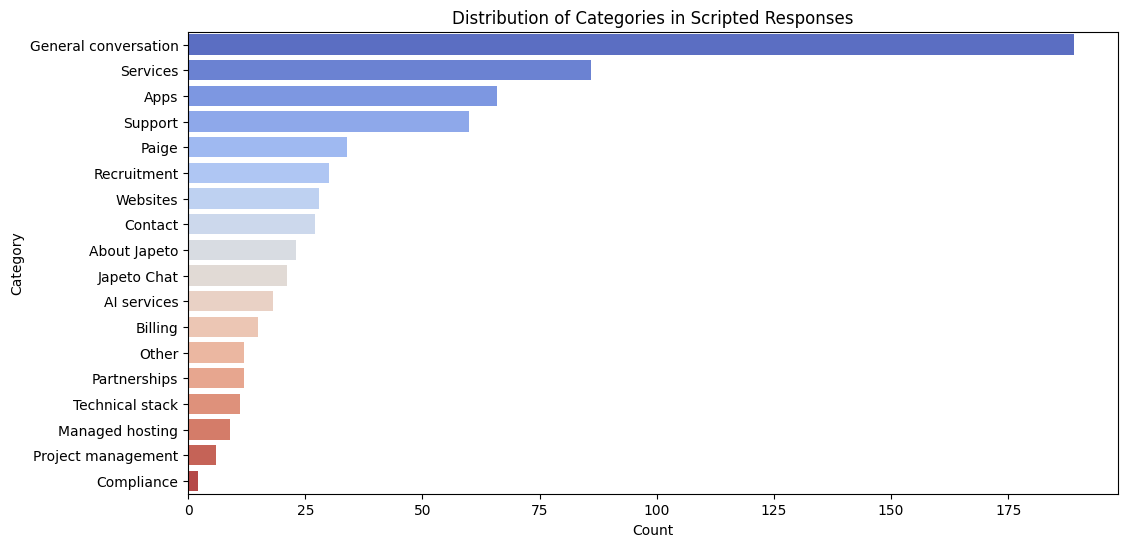

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters: {'clf__C': 10, 'tfidf__max_df': 0.9, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__sublinear_tf': True}
Validation Classification Report:
                      precision    recall  f1-score   support

         AI services       0.75      0.75      0.75         4
        About Japeto       0.50      0.40      0.44         5
                Apps       0.93      1.00      0.96        13
             Billing       1.00      1.00      1.00         3
             Contact       1.00      0.83      0.91         6
General conversation       0.90      0.97      0.94        38
         Japeto Chat       1.00      0.75      0.86         4
     Managed hosting       0.25      0.50      0.33         2
               Other       1.00      1.00      1.00         2
               Paige       0.78      1.00      0.88         7
        Partnerships       1.00      1.00      1.00         2
  Project management      

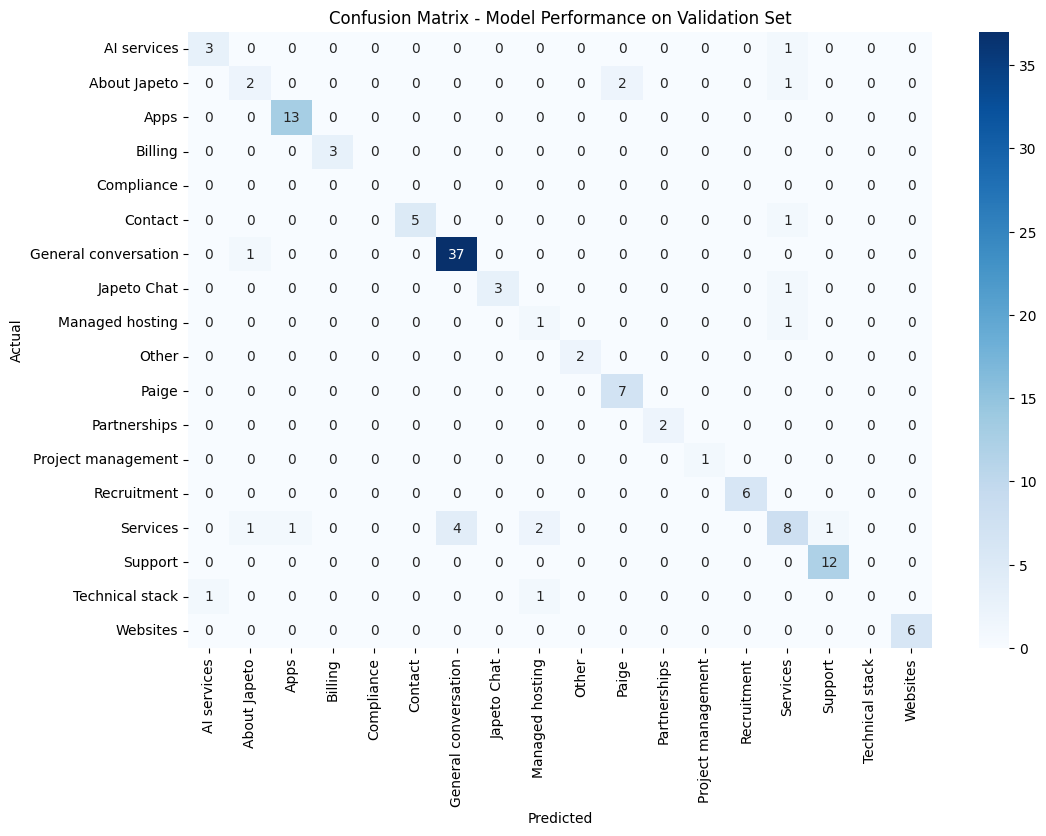

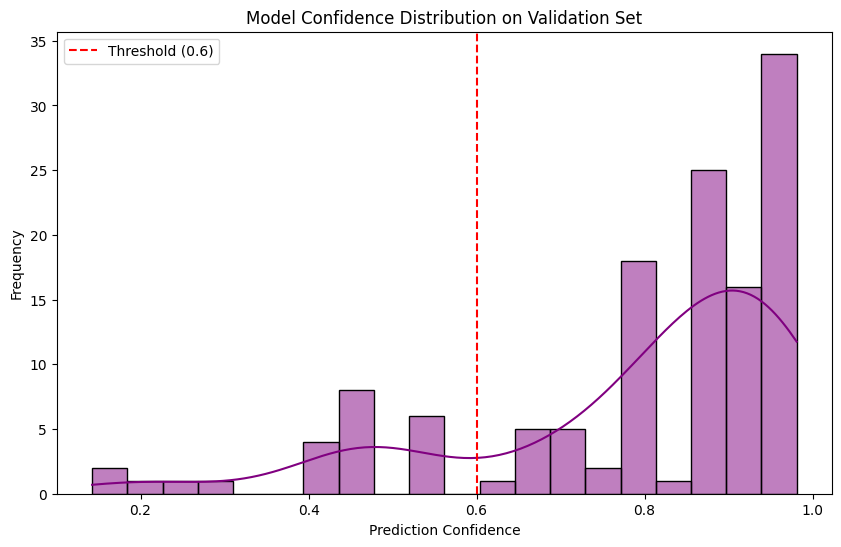

Predicted Category for sample message: Manual Tagging Required


In [14]:
import os
import re
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Suppress warnings
warnings.filterwarnings("ignore")

# Check if running on Kaggle
if 'KAGGLE_URL_BASE' in os.environ:
    print("Detected Kaggle environment.")
    dataset_path = '/kaggle/input/my-classified-project/chatbot_dataset.xlsx'
else:
    dataset_path = 'chatbot_dataset.xlsx'

# Load the dataset
df = pd.read_excel(dataset_path)
print("Dataset columns:", df.columns.tolist())

# Map expected columns to actual dataset columns
def find_column(df, candidates):
    for candidate in candidates:
        if candidate in df.columns:
            return candidate
    return None

# Candidate names for required columns
category_col = find_column(df, ['categories', 'Categories', 'cat'])
response_type_col = find_column(df, ['response_source', 'Response Source', 'type'])
chatbot_response_col = find_column(df, ['chatbot_response', 'Chatbot Response', 'response'])

missing = []
if not category_col:
    missing.append('categories')
if not response_type_col:
    missing.append('response_source')
if not chatbot_response_col:
    missing.append('chatbot_response')
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Filter only scripted responses for training
df_scripted = df[df[response_type_col] == 'NLU']
if df_scripted.empty:
    raise ValueError("No scripted responses found. Please check the 'response_source' values.")

# Visualize category distribution in training data
plt.figure(figsize=(12, 6))
sns.countplot(y=df_scripted[category_col], order=df_scripted[category_col].value_counts().index, palette="coolwarm")
plt.title("Distribution of Categories in Scripted Responses")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

# Prepare features and labels
X = df_scripted[chatbot_response_col]
y = df_scripted[category_col]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define a custom preprocessor
def custom_preprocessor(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Create a text classification pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', preprocessor=custom_preprocessor)),
    ('clf', LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial'))
])

# Expand hyperparameter grid for tuning
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.9, 0.95],
    'tfidf__min_df': [1, 2],
    'tfidf__sublinear_tf': [True, False],
    'clf__C': [0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

# Train using GridSearchCV
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

best_pipeline = grid_search.best_estimator_

# Evaluate the tuned model on the validation set
y_pred = best_pipeline.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_val, y_pred, labels=best_pipeline.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_pipeline.classes_, yticklabels=best_pipeline.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Model Performance on Validation Set")
plt.show()

# Define a function to predict a category for new AI-generated responses
def predict_category(message, threshold=0.6):
    """
    Predict the category for a new AI-generated chatbot response.
    
    Parameters:
        message (str): The new AI-generated response text.
        threshold (float): Confidence threshold for categorization.
        
    Returns:
        str: Predicted category or "Manual Tagging Required" if confidence is low.
    """
    probs = best_pipeline.predict_proba([message])[0]
    max_prob = max(probs)
    pred_category = best_pipeline.classes_[probs.argmax()]
    
    if max_prob < threshold:
        return "Manual Tagging Required"
    
    return pred_category

# Analyze Model Confidence Levels
probs = best_pipeline.predict_proba(X_val)
max_probs = probs.max(axis=1)

plt.figure(figsize=(10, 6))
sns.histplot(max_probs, bins=20, kde=True, color="purple")
plt.axvline(0.6, color='red', linestyle='--', label="Threshold (0.6)")
plt.title("Model Confidence Distribution on Validation Set")
plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Example usage of the prediction function
new_ai_response = "Your new AI-generated chatbot response goes here."
predicted_category = predict_category(new_ai_response, threshold=0.6)
print("Predicted Category for sample message:", predicted_category)
